# Plot ENSO

Coupled models only. Use Fig 14 in Bi et al. 2020 as example.

In [117]:
import cosima_cookbook as cc
from dask.distributed import Client

import xarray as xr
import matplotlib.pyplot as plt
import cmocean as cm
import numpy as np
%matplotlib inline

import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec

# Stop annoying warnings coming out of xarray.
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/35035/status,
Dashboard: /proxy/35035/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42701,Workers: 7
Dashboard: /proxy/35035/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:33437,Total threads: 4
Dashboard: /proxy/46871/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:33645,


In [3]:
# CM2 database
#session_CM2 = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/cj877.db') 
session_CM2 = cc.database.create_session('/g/data/p73/archive/non-CMIP/ACCESS-CM2/CM2.db')
expt_CM2_025 = 'cj877'
expt_CM2_1   = 'bz687'

In [4]:
# OM2 database
session_OM2  = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt_OM2_025 = '025deg_jra55_ryf9091_gadi'
expt_OM2_1   = '1deg_jra55_ryf9091_gadi'

In [5]:
path_to_data = '/g/data/x77/wgh581/Post_Process/ACCESS_CM2_025/'

If you get a 'read-only database' warning, it is because the database has not finished building. 

In [121]:
# Plotting info
ft_size = 16
plt.rcParams.update({'font.size': ft_size})
fig_path = '/g/data/x77/wgh581/Figures/Figures_ACCESS_CM2/'

In [71]:
CLEX_Red = '#DA1E48'
CLEX_Pink = '#F48580'
CLEX_SkyBlue = '#00BDF2'
CLEX_MidBlue = '#008DD0'
CLEX_CobaldBlue = '#0066B3'
CLEX_MidnightBlue = '#113559'
CLEX_Gray = '#4D4D47'

### Import SST fields

In [7]:
start_time = '0001-01-01'
end_time   = '0499-12-31'

In [41]:
lon_range = slice(-150, -80)
lat_range = slice(-30, 30)

nino3_lon = slice(-150, -90)
nino3_lat = slice(-5, 5)

In [15]:
SST_CM2_025 = xr.open_dataarray(path_to_data + 'SST_global_annual.nc')
SST_CM2_025 = SST_CM2_025.sel(time=slice(start_time, end_time))
SST_CM2_025 = SST_CM2_025.sel(xt_ocean=lon_range).sel(yt_ocean=lat_range)

In [16]:
SST_CM2_1 = xr.open_dataarray(path_to_data + 'Comparison_ACCESS_CM2_1/SST_CM2_1_annual.nc')
SST_CM2_1 = SST_CM2_1.sel(time=slice(start_time, end_time))
SST_CM2_1 = SST_CM2_1.sel(xt_ocean=lon_range).sel(yt_ocean=lat_range)

NINO3 index, power spectrum

In [50]:
nino3_CM2_025 = SST_CM2_025.sel(xt_ocean=nino3_lon).sel(yt_ocean=nino3_lat)
nino3_CM2_025 = nino3_CM2_025.mean('xt_ocean').mean('yt_ocean')

nino3_CM2_1 = SST_CM2_1.sel(xt_ocean=nino3_lon).sel(yt_ocean=nino3_lat)
nino3_CM2_1 = nino3_CM2_1.mean('xt_ocean').mean('yt_ocean')

In [47]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [51]:
nino3_CM2_025 = detrend_dim(nino3_CM2_025, 'time')
nino3_CM2_1 = detrend_dim(nino3_CM2_1, 'time')

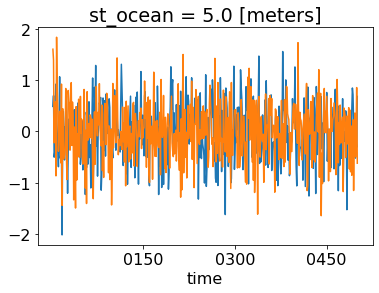

In [52]:
nino3_CM2_025.plot()
nino3_CM2_1.plot()

In [53]:
def get_spectrum(data):
    sampling_rate = 1
    fourier_transform = np.fft.rfft(data)
    abs_fourier_transform = np.abs(fourier_transform)
    power_spectrum = np.square(abs_fourier_transform)
    frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))
    
    return frequency, power_spectrum

In [54]:
freq_CM2_025, ps_CM2_025 = get_spectrum(nino3_CM2_025)
freq_CM2_1, ps_CM2_1 = get_spectrum(nino3_CM2_1)

200 years
9 years
5 years
3 years
3 years


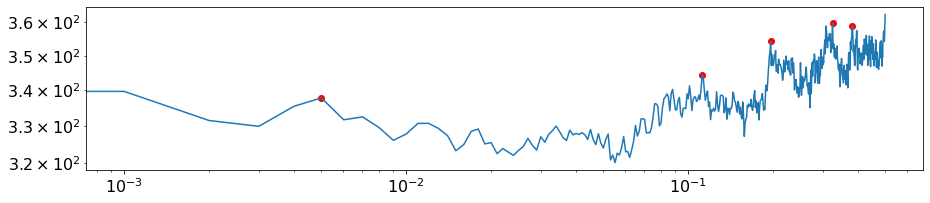

In [11]:
fig = plt.figure(figsize=(15,3))

plt.loglog(freq, ps[:,0])
maxima = [5, 112, 196, 325, 382]
for ii in maxima:
    plt.scatter(freq[ii], ps[ii], color='r')
    print(int(np.round(1/freq[ii])), 'years')

(0.0, 750.0)

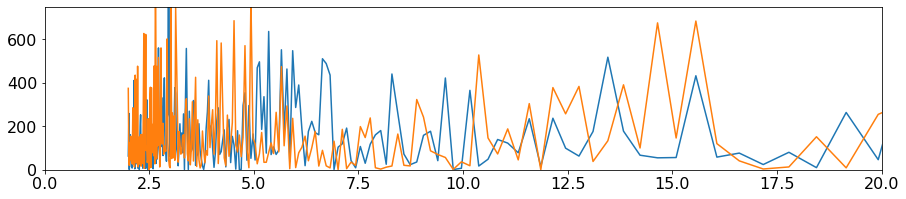

In [70]:
fig = plt.figure(figsize=(15,3))

plt.plot(1/freq_CM2_025, ps_CM2_025)
plt.plot(1/freq_CM2_1, ps_CM2_1)
plt.xlim(0, 20)
plt.ylim(0,750)
# maxima = [5, 112, 196, 325, 382]
# for ii in maxima:
#     plt.scatter(freq[ii], ps[ii], color='r')
#     print(int(np.round(1/freq[ii])), 'years')

### Plotting

In [114]:
# import cartopy.feature as cft

# land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='darkgrey', linewidth=0.5)

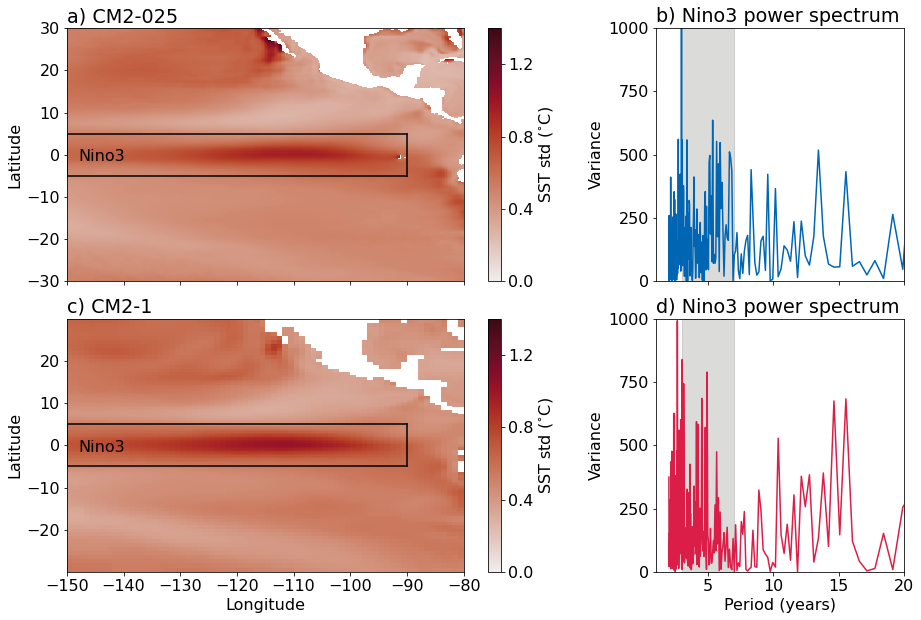

In [122]:
fig = plt.figure(figsize=(15,10))
gs  = gridspec.GridSpec(2, 2, width_ratios=[1, 0.5], hspace=0.15, wspace=0.25)

ax = fig.add_subplot(gs[0,0])#, projection=ccrs.Robinson(central_longitude=-100))
SST_CM2_025.std('time').plot(cmap=cm.cm.amp, vmin=0, vmax=1.4, cbar_kwargs={'label':'SST std ($^{\circ}$C)', 'ticks':np.arange(0, 1.6, 0.4)})
plt.title('')
plt.title('a) CM2-025', loc='left')
plt.tick_params(labelbottom=False)
plt.xlabel('')
plt.ylabel('Latitude')
plt.plot([-150, -90], [-5, -5], color='k')
plt.plot([-150, -90], [5, 5], color='k')
plt.plot([-150, -150], [-5, 5], color='k')
plt.plot([-90, -90], [-5, 5], color='k')
plt.text(-148, -1.5, 'Nino3')

ax = fig.add_subplot(gs[0,1])
plt.plot(1/freq_CM2_025, ps_CM2_025, color=CLEX_CobaldBlue)
plt.xlim(1,20)
plt.ylim(0,1000)
plt.yticks(np.arange(0, 1100, 250))
plt.tick_params(labelbottom=False)
plt.title('b) Nino3 power spectrum', loc='left')
plt.fill_between([3, 7], 0, 1000, color=CLEX_Gray, alpha=0.2)
plt.ylabel('Variance')

ax = fig.add_subplot(gs[1,0])#, projection=ccrs.Robinson(central_longitude=-100))
SST_CM2_1.std('time').plot(cmap=cm.cm.amp, vmin=0, vmax=1.4, cbar_kwargs={'label':'SST std ($^{\circ}$C)', 'ticks':np.arange(0, 1.6, 0.4)})
plt.title('')
plt.title('c) CM2-1', loc='left')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.plot([-150, -90], [-5, -5], color='k')
plt.plot([-150, -90], [5, 5], color='k')
plt.plot([-150, -150], [-5, 5], color='k')
plt.plot([-90, -90], [-5, 5], color='k')
plt.text(-148, -1.5, 'Nino3')

ax = fig.add_subplot(gs[1,1])
plt.plot(1/freq_CM2_1, ps_CM2_1, color=CLEX_Red)
plt.xlim(1,20)
plt.ylim(0,1000)
plt.yticks(np.arange(0, 1100, 250))
plt.xlabel('Period (years)')
plt.title('d) Nino3 power spectrum', loc='left')
plt.fill_between([3, 7], 0, 1000, color=CLEX_Gray, alpha=0.2)
plt.ylabel('Variance')

# Finished
save_flag = 1
if save_flag == 1:
    fig_name = 'Fig_ENSO_nino3.png'
    plt.savefig(fig_path + fig_name, dpi=300);